In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, probplot
from sklearn.model_selection import train_test_split
pd.set_option('max_columns', 5000)
sns.set_style('darkgrid')
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings(action='ignore')

sns.set(rc={'figure.figsize':(12,10)})

In [2]:
data = pd.read_excel('IMDb_database.xlsx')
data.head()

,Rank,Title,Year,Certificate,Runtime,Genre,Rating,Metascore,Votes,Gross,URL,Intro
0,1,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,84,2428474,534858444,https://imdb.com/title/tt0468569/,When the menace known as the Joker wreaks havo...
1,2,The Lord of the Rings: The Return of the King,2003,PG-13,201 min,"Action, Adventure, Drama",8.9,94,1715249,377845905,https://imdb.com/title/tt0167260/,Gandalf and Aragorn lead the World of Men agai...
2,3,Inception,2010,PG-13,148 min,"Action, Adventure, Sci-Fi",8.8,74,2179206,292576195,https://imdb.com/title/tt1375666/,A thief who steals corporate secrets through t...
3,4,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,178 min,"Action, Adventure, Drama",8.8,92,1736538,315544750,https://imdb.com/title/tt0120737/,A meek Hobbit from the Shire and eight compani...
4,5,The Mountain II,2016,,135 min,"Action, Drama, War",8.7,,106888,,https://imdb.com/title/tt5813916/,In a desolate war zone where screams of the in...


In [3]:
data.describe()

,Rank,Year,Rating,Votes
count,17483.000000,17483.000000,17483.000000,1.748300e+04
mean,757.889950,2002.676028,6.718286,1.358193e+05
std,665.311836,15.738938,0.954680,1.830410e+05
min,1.000000,1920.000000,1.000000,2.501600e+04
25%,233.000000,1997.000000,6.200000,4.090300e+04
50%,576.000000,2007.000000,6.800000,7.180000e+04
75%,1094.000000,2014.000000,7.400000,1.497080e+05
max,3015.000000,2021.000000,9.300000,2.474457e+06


In [4]:
m = data['Metascore'].unique()
m[4] == ' '

True

In [5]:
data['Metascore'] = data['Metascore'].replace(' ',np.nan)
data['Certificate'] = data['Certificate'].replace(' ',np.nan)
data['Gross'] = data['Gross'].replace(' ',np.nan)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17483 entries, 0 to 17482
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         17483 non-null  int64  
 1   Title        17483 non-null  object 
 2   Year         17483 non-null  int64  
 3   Certificate  17368 non-null  object 
 4   Runtime      17483 non-null  object 
 5   Genre        17483 non-null  object 
 6   Rating       17483 non-null  float64
 7   Metascore    7521 non-null   float64
 8   Votes        17483 non-null  int64  
 9   Gross        15234 non-null  float64
 10  URL          17483 non-null  object 
 11  Intro        17483 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 1.6+ MB


In [7]:
data.corr(method='pearson')

,Rank,Year,Rating,Metascore,Votes,Gross
Rank,1.000000,0.195451,-0.544336,-0.277287,-0.265721,-0.142131
Year,0.195451,1.000000,-0.274793,-0.315174,0.051999,0.124838
Rating,-0.544336,-0.274793,1.000000,0.526936,0.360469,0.097617
Metascore,-0.277287,-0.315174,0.526936,1.000000,0.166493,0.017112
Votes,-0.265721,0.051999,0.360469,0.166493,1.000000,0.588034
Gross,-0.142131,0.124838,0.097617,0.017112,0.588034,1.000000


array([[<AxesSubplot:title={'center':'Rank'}>,
        <AxesSubplot:title={'center':'Year'}>],
       [<AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'Metascore'}>],
       [<AxesSubplot:title={'center':'Votes'}>,
        <AxesSubplot:title={'center':'Gross'}>]], dtype=object)

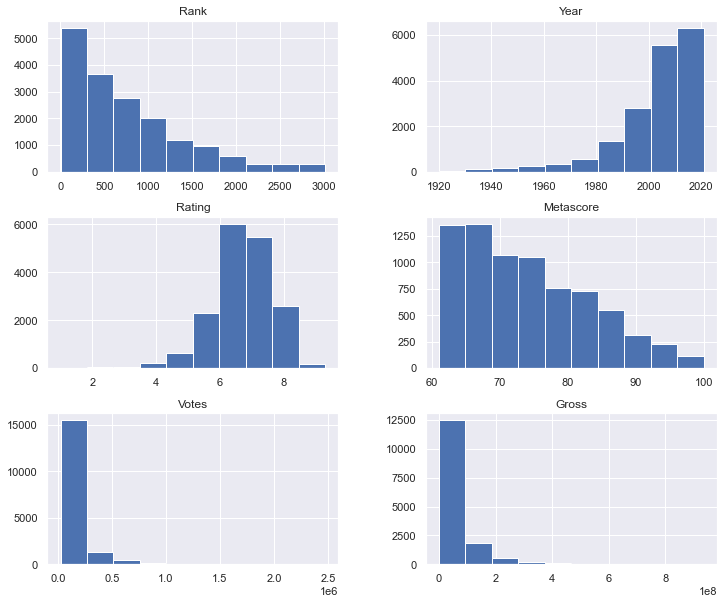

In [8]:
data.hist()

In [9]:
# get the movie_time_min from Runtime with apply mehtod
x = lambda x: int(x.split(' ')[0])
data['Movie_time_min'] = data['Runtime'].apply(x)
data.head(1)

,Rank,Title,Year,Certificate,Runtime,Genre,Rating,Metascore,Votes,Gross,URL,Intro,Movie_time_min
0,1,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,84.0,2428474,534858444.0,https://imdb.com/title/tt0468569/,When the menace known as the Joker wreaks havo...,152


In [10]:
# get the all genres
g = data['Genre'].unique()
l = []
for i in range(len(g)):
    tmp = g[i].split(',')
    for j in tmp:
        if j not in l:
            l.append(j)
l = [x.strip() for x in l]
l = set(l)
len(l)

21

In [11]:
# add column for each genre
tmp = [x.replace(' ','').split(',') for x in data['Genre'].tolist()]
for i in l:
    data[i] = 0

for i in range(13,34):
    for j in range(len(tmp)):
        if data.columns[i] in tmp[j]:
            data.iloc[j,i] = 1
        else:
            data.iloc[j,i] = 0
data.sample(5)

,Rank,Title,Year,Certificate,Runtime,Genre,Rating,Metascore,Votes,Gross,URL,Intro,Movie_time_min,History,Biography,Horror,Adventure,Animation,Sport,Thriller,Drama,Western,Action,Mystery,Music,Romance,Film-Noir,War,Comedy,Family,Musical,Sci-Fi,Fantasy,Crime
15471,254,The Impossible,2012,PG-13,114 min,"Drama, History, Thriller",7.6,73.0,212020,19019882.0,https://imdb.com/title/tt1649419/,The story of a tourist family in Thailand caug...,114,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9984,336,The Water Horse,2007,PG,112 min,"Adventure, Family, Fantasy",6.4,71.0,39385,40412817.0,https://imdb.com/title/tt0760329/,A lonely boy discovers a mysterious egg that h...,112,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
16148,931,I'm Thinking of Ending Things,2020,R,134 min,"Drama, Thriller",6.6,78.0,74525,NaN,https://imdb.com/title/tt7939766/,"Full of misgivings, a young woman travels with...",134,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
14778,556,Krull,1983,PG,121 min,"Action, Adventure, Fantasy",6.1,NaN,31845,16519460.0,https://imdb.com/title/tt0085811/,A prince and a fellowship of companions set ou...,121,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
13456,401,The One I Love,2014,R,91 min,"Comedy, Drama, Romance",7.1,66.0,38175,511635.0,https://imdb.com/title/tt2756032/,A troubled couple vacate to a beautiful getawa...,91,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0


In [12]:
data.describe()

,Rank,Year,Rating,Metascore,Votes,Gross,Movie_time_min,History,Biography,Horror,Adventure,Animation,Sport,Thriller,Drama,Western,Action,Mystery,Music,Romance,Film-Noir,War,Comedy,Family,Musical,Sci-Fi,Fantasy,Crime
count,17483.000000,17483.000000,17483.000000,7521.000000,1.748300e+04,1.523400e+04,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000
mean,757.889950,2002.676028,6.718286,73.967558,1.358193e+05,5.749955e+07,111.065035,0.037865,0.080764,0.112624,0.280844,0.094091,0.018532,0.151118,0.520906,0.006807,0.340102,0.117943,0.025510,0.133844,0.005434,0.014929,0.362695,0.061260,0.012698,0.093176,0.103987,0.234170
std,665.311836,15.738938,0.954680,9.465180,1.830410e+05,7.897623e+07,21.059282,0.190876,0.272480,0.316141,0.449424,0.291964,0.134870,0.358174,0.499577,0.082223,0.473757,0.322550,0.157674,0.340495,0.073516,0.121271,0.480792,0.239813,0.111971,0.290688,0.305252,0.423491
min,1.000000,1920.000000,1.000000,61.000000,2.501600e+04,4.410000e+02,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,233.000000,1997.000000,6.200000,66.000000,4.090300e+04,8.586380e+06,97.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,576.000000,2007.000000,6.800000,72.000000,7.180000e+04,3.259893e+07,107.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1094.000000,2014.000000,7.400000,81.000000,1.497080e+05,7.158392e+07,121.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3015.000000,2021.000000,9.300000,100.000000,2.474457e+06,9.366622e+08,321.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'PG-13'),
  Text(1, 0, 'R'),
  Text(2, 0, 'PG'),
  Text(3, 0, 'Not Rated'),
  Text(4, 0, 'Passed'),
  Text(5, 0, 'TV-MA'),
  Text(6, 0, 'TV-14'),
  Text(7, 0, 'G'),
  Text(8, 0, 'Approved'),
  Text(9, 0, 'M'),
  Text(10, 0, 'TV-PG'),
  Text(11, 0, 'M/PG'),
  Text(12, 0, 'GP'),
  Text(13, 0, 'Unrated'),
  Text(14, 0, 'NC-17'),
  Text(15, 0, 'TV-G'),
  Text(16, 0, 'X')])

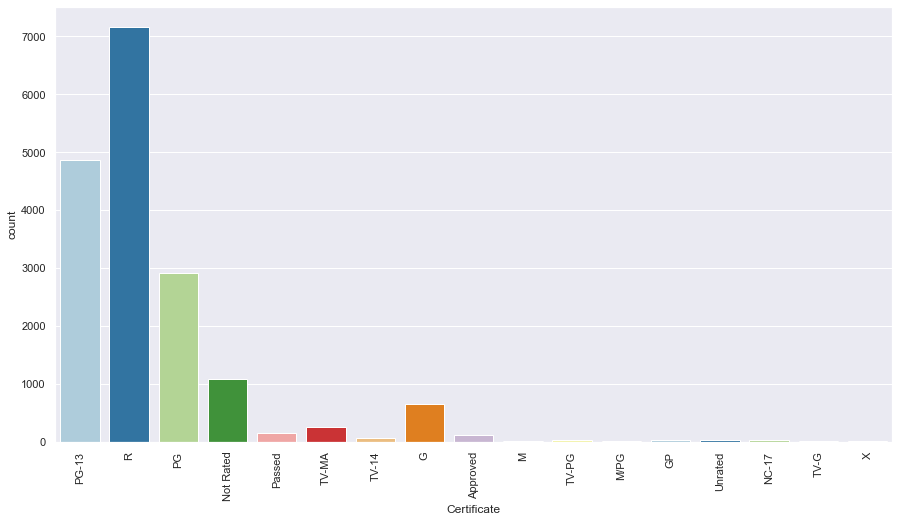

In [13]:
# countplot for certificate
plt.figure(figsize = (15,8))
sns.color_palette("magma", as_cmap=True)
ax = sns.countplot(x='Certificate', data= data, palette='Paired')
plt.xticks(rotation= 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '1.1'),
  Text(2, 0, '1.2'),
  Text(3, 0, '1.4'),
  Text(4, 0, '1.8'),
  Text(5, 0, '1.9'),
  Text(6, 0, '2.0'),
  Text(7, 0, '2.1'),
  Text(8, 0, '2.2'),
  Text(9, 0, '2.4'),
  Text(10, 0, '2.5'),
  Text(11, 0, '2.7'),
  Text(12, 0, '2.8'),
  Text(13, 0, '2.9'),
  Text(14, 0, '3.0'),
  Text(15, 0, '3.1'),
  Text(16, 0, '3.2'),
  Text(17, 0, '3.3'),
  Text(18, 0, '3.4'),
  Text(19, 0, '3.5'),
  Text(20, 0, '3.6'),
  Text(21, 0, '3.7'),
  Text(22, 0, '3.8'),
  Text(23, 0, '3.9'),
  Text(24, 0, '4.0'),
  Text(25, 0, '4.1'),
  Text(26, 0, '4.2'),
  Text(27, 0, '4.3'),
  Text(28, 0, '4.4'),
  Text(29, 0, '4.5

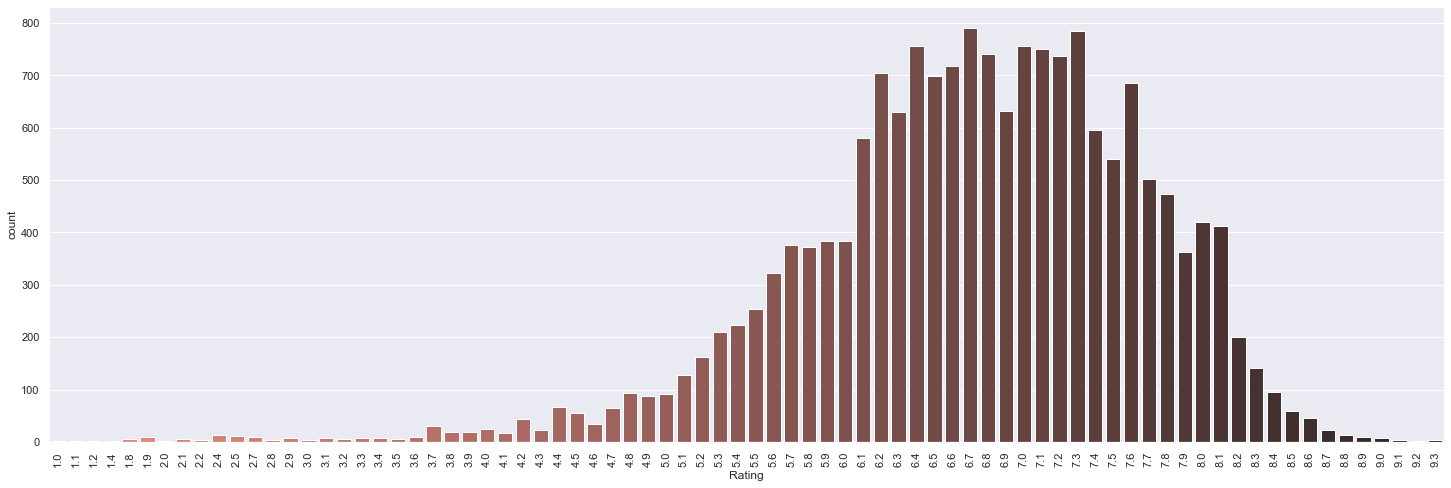

In [23]:
# countplot rating
plt.figure(figsize = (25,8))
ax = sns.countplot(x='Rating', data= data, palette='dark:salmon_r')
plt.xticks(rotation= 90)

Rating's skew: 0.9362600609348642
Rating's kurt: -0.707134955101866


((array([-2.37195453, -2.02429227, -1.82195584, -1.67475005, -1.55685515,
         -1.45732576, -1.37044486, -1.29283054, -1.22230774, -1.15739046,
         -1.09701584, -1.04039577, -0.98692856, -0.93614359, -0.88766522,
         -0.8411883 , -0.79646114, -0.75327338, -0.71144706, -0.67082998,
         -0.63129074, -0.59271479, -0.55500149, -0.51806168, -0.48181576,
         -0.44619218, -0.41112616, -0.37655864, -0.34243544, -0.30870647,
         -0.27532518, -0.24224798, -0.20943379, -0.17684364, -0.14444028,
         -0.11218792, -0.08005187, -0.04799829, -0.01599397,  0.01599397,
          0.04799829,  0.08005187,  0.11218792,  0.14444028,  0.17684364,
          0.20943379,  0.24224798,  0.27532518,  0.30870647,  0.34243544,
          0.37655864,  0.41112616,  0.44619218,  0.48181576,  0.51806168,
          0.55500149,  0.59271479,  0.63129074,  0.67082998,  0.71144706,
          0.75327338,  0.79646114,  0.8411883 ,  0.88766522,  0.93614359,
          0.98692856,  1.04039577,  1.

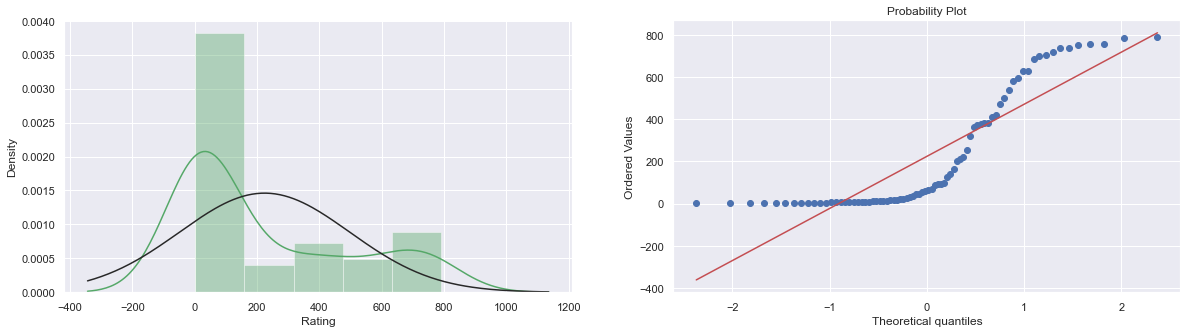

In [24]:
# If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
# If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
# If the skewness is less than -1 or greater than 1, the data are highly skewed
# Skewness is a measure of asymmetry of a distribution

# Kurtosis describes the peakedness of the distribution.
# High kurtosis in a data set is an indicator that data has heavy outliers.
# Low kurtosis in a data set is an indicator that data has lack of outliers.
# If kurtosis value + means pointy and — means flat.

rating_count = data.groupby('Rating')['Rating'].count()
print(f"Rating's skew: {rating_count.skew()}")
print(f"Rating's kurt: {rating_count.kurt()}")
f, ax = plt.subplots(1,2, figsize=(20,5))
rating_count = rating_count.to_frame()
sns.distplot(rating_count.Rating, fit=norm,color='g',ax=ax[0])
probplot(rating_count.Rating,plot=ax[1])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151]),
 [Text(0, 0, '45'),
  Text(1, 0, '46'),
  Text(2, 0, '63'),
  Text(3, 0, '64'),
  Text(4, 0, '66'),
  Text(5, 0, '67'),
  Text(6, 0, '68'),
  

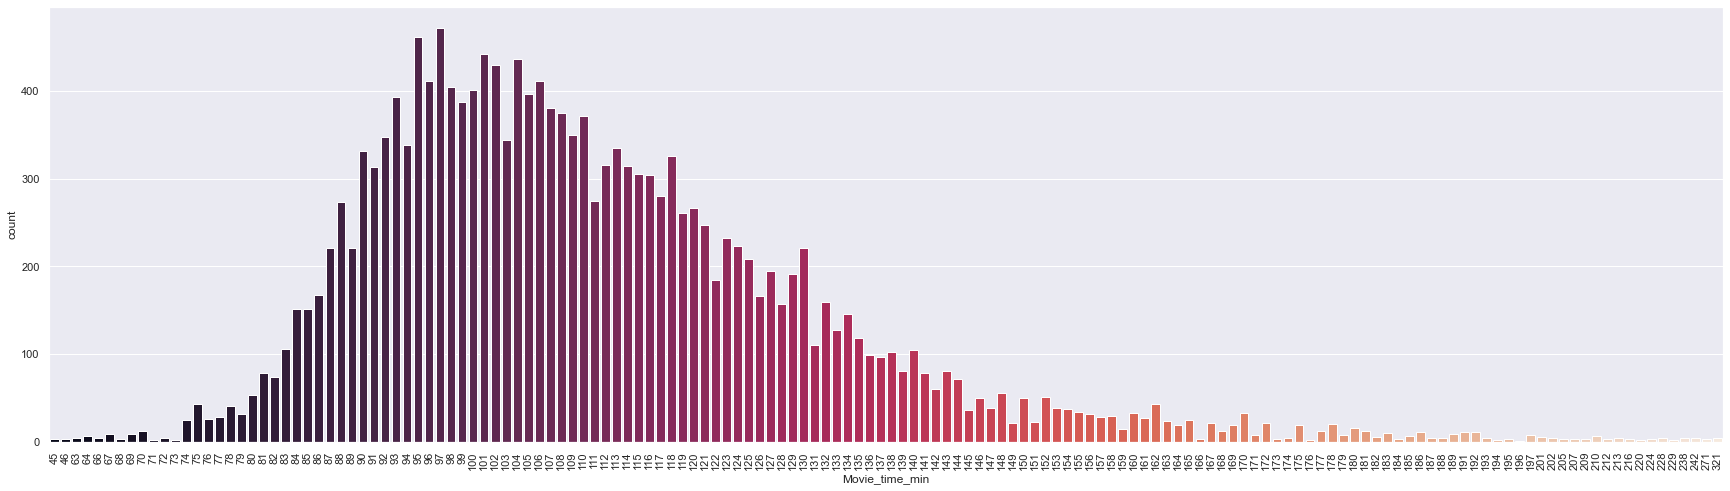

In [25]:
# countplot for Runtime
plt.figure(figsize = (30,8))
sns.color_palette("magma", as_cmap=True)
ax = sns.countplot(x='Movie_time_min', data= data, palette='rocket')
plt.xticks(rotation= 90)

Movie_time_min's skew: 1.0928078330565965
Movie_time_min's kurt: -0.24792844339791253


((array([-2.60828957, -2.28890067, -2.10591774, -1.97438596, -1.87014095,
         -1.78297348, -1.7075655 , -1.64077866, -1.58059905, -1.52565375,
         -1.474963  , -1.42780197, -1.3836187 , -1.34198267, -1.30255131,
         -1.26504733, -1.22924293, -1.1949486 , -1.16200487, -1.1302762 ,
         -1.09964636, -1.07001489, -1.0412943 , -1.01340792, -0.98628816,
         -0.95987505, -0.93411519, -0.90896073, -0.88436868, -0.86030017,
         -0.83672   , -0.81359614, -0.79089936, -0.76860288, -0.74668211,
         -0.72511441, -0.70387886, -0.68295608, -0.6623281 , -0.64197819,
         -0.62189074, -0.60205115, -0.58244576, -0.56306175, -0.54388703,
         -0.52491024, -0.50612064, -0.48750805, -0.46906285, -0.45077588,
         -0.43263844, -0.41464222, -0.39677931, -0.37904213, -0.3614234 ,
         -0.34391617, -0.32651373, -0.30920962, -0.29199761, -0.27487168,
         -0.257826  , -0.2408549 , -0.22395291, -0.20711465, -0.19033491,
         -0.1736086 , -0.15693072, -0.

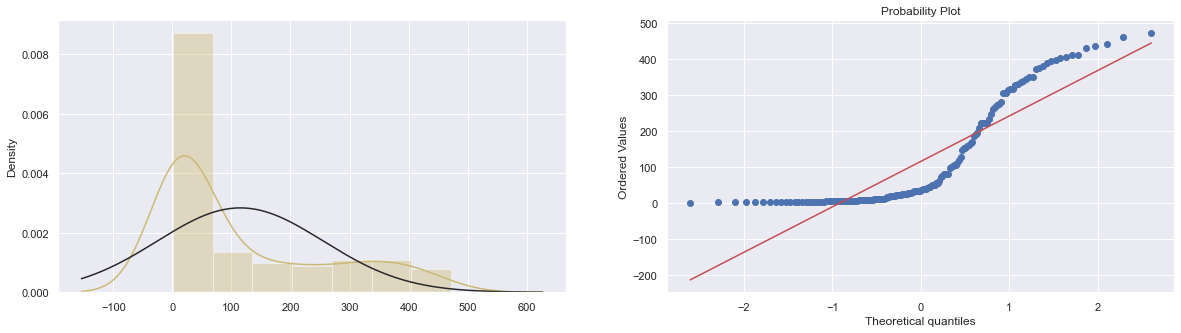

In [26]:
Movie_time_min_count = data.groupby('Movie_time_min')['Movie_time_min'].count()
print(f"Movie_time_min's skew: {Movie_time_min_count.skew()}")
print(f"Movie_time_min's kurt: {Movie_time_min_count.kurt()}")
f, ax = plt.subplots(1,2, figsize=(20,5))
Movie_time_min_count = Movie_time_min_count.to_frame()
sns.distplot(Movie_time_min_count, fit=norm,color='y',ax=ax[0])
probplot(Movie_time_min_count.Movie_time_min,plot=ax[1])

(array([1900., 1920., 1940., 1960., 1980., 2000., 2020., 2040.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

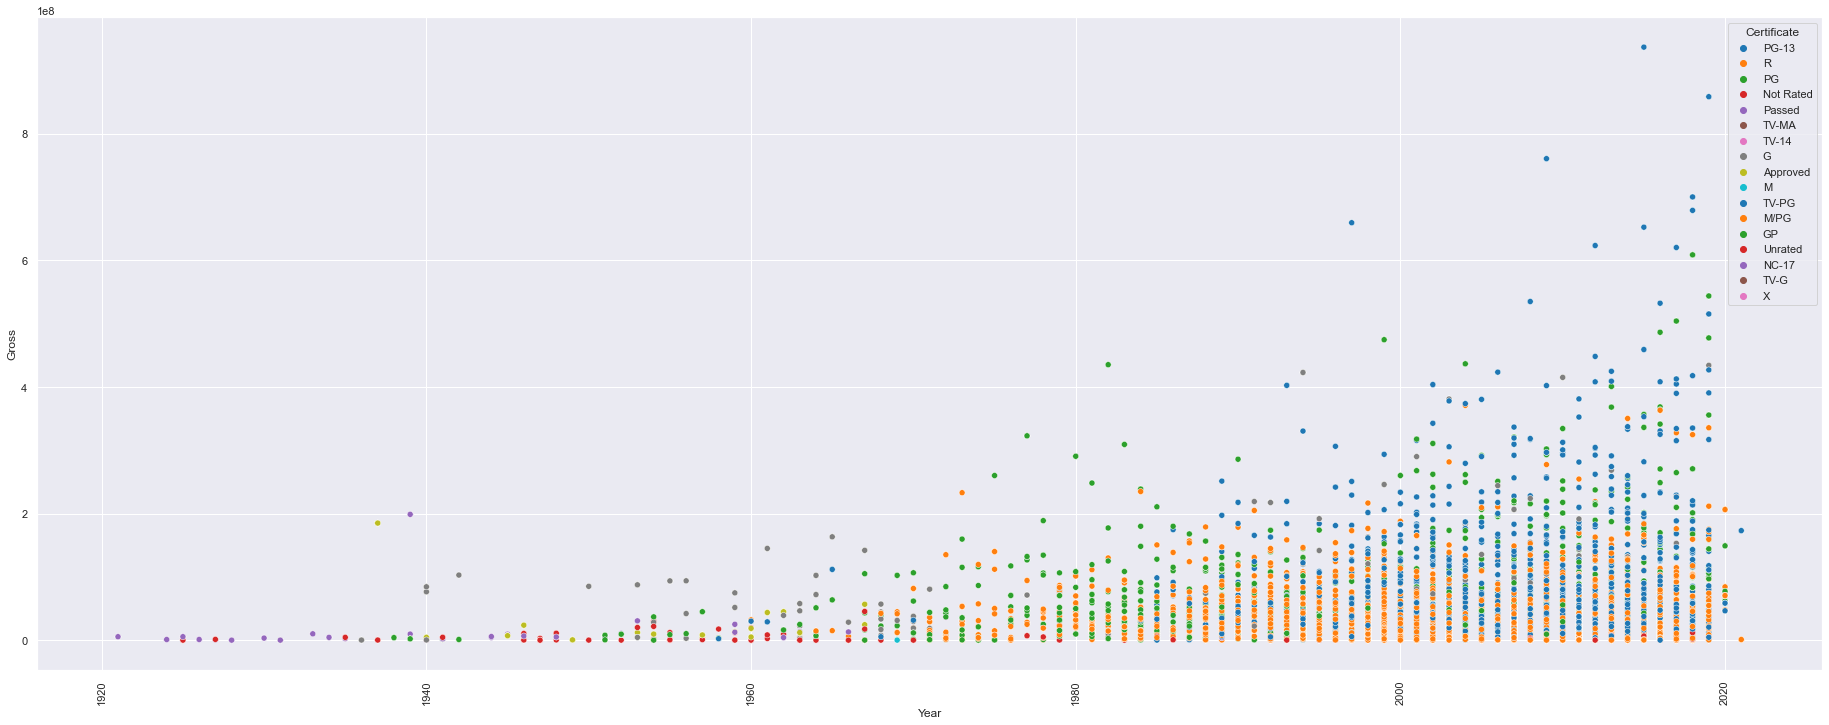

In [27]:

plt.figure(figsize = (32,12))
ax = sns.scatterplot(x='Year', y='Gross', data= data,hue='Certificate', palette='tab10')
plt.xticks(rotation= 90)

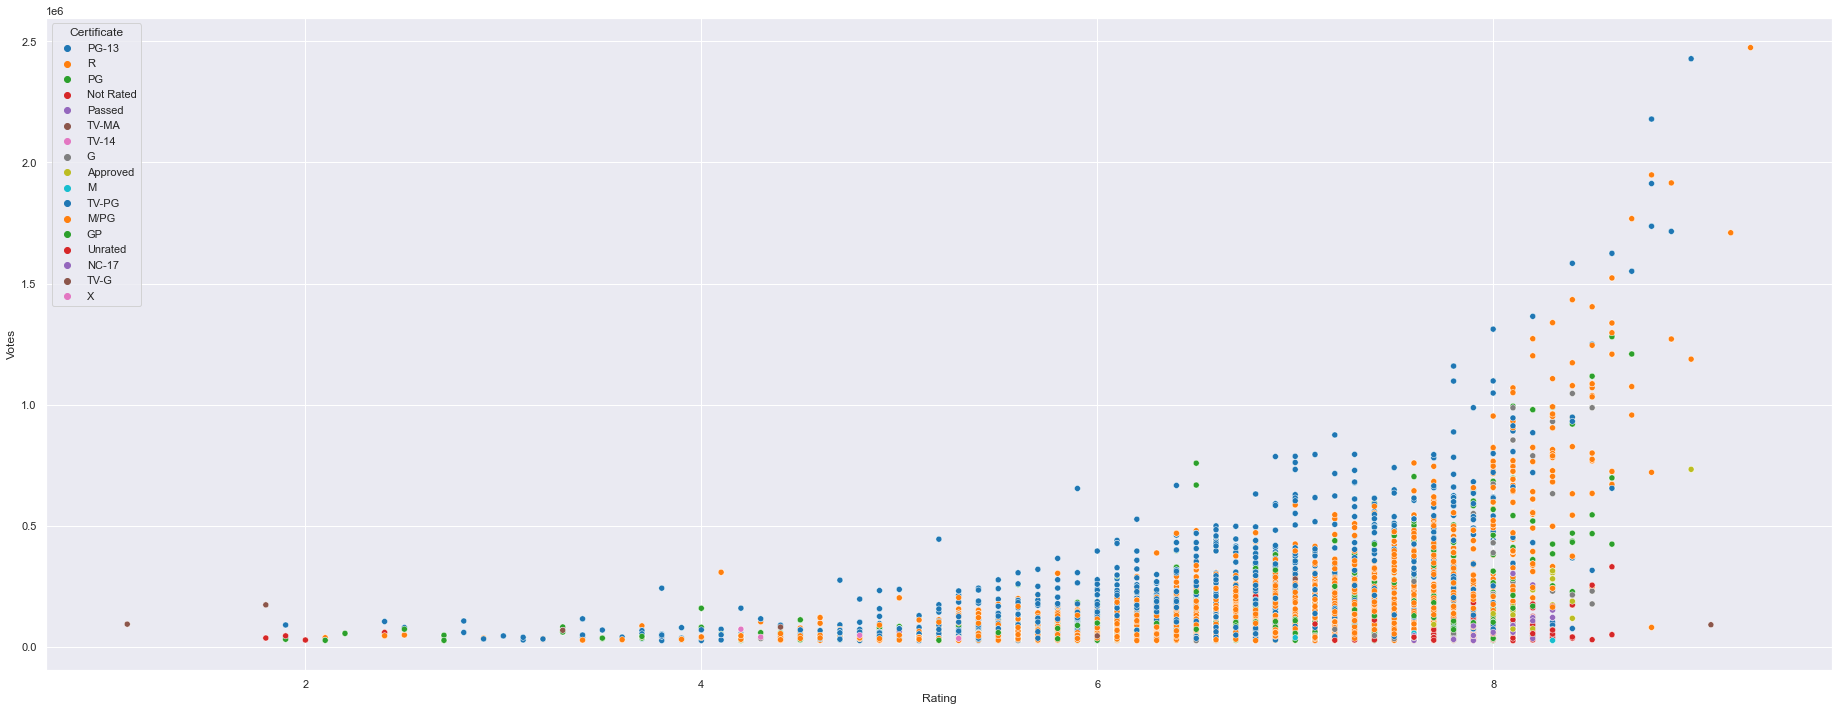

In [28]:
plt.figure(figsize = (32,12))
ax = sns.scatterplot(x='Rating', y='Votes', data= data,hue='Certificate', palette='tab10')

<AxesSubplot:title={'center':'Mean Rating Per Year'}, xlabel='Year'>

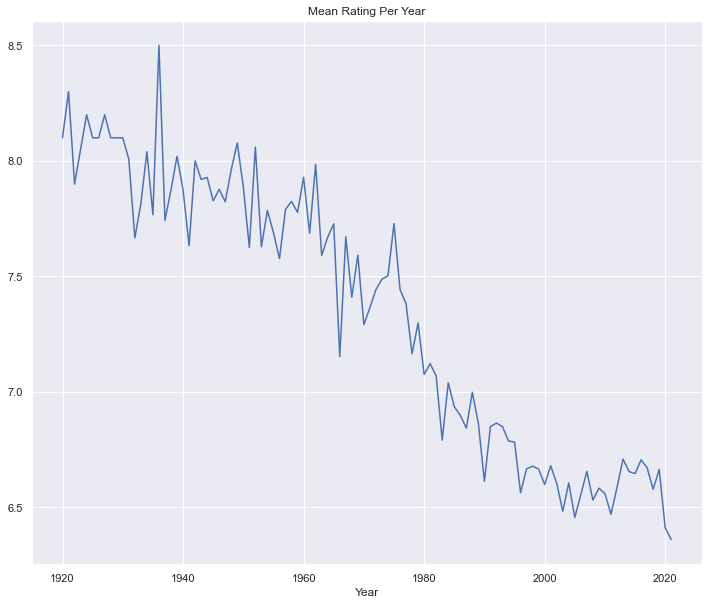

In [29]:
# mean rating for each year
mean_rating_year = data.groupby(by=['Year'])['Rating'].mean()
mean_rating_year.plot(title='Mean Rating Per Year')

<AxesSubplot:title={'center':'Mean Movie Time Per Year'}, xlabel='Year'>

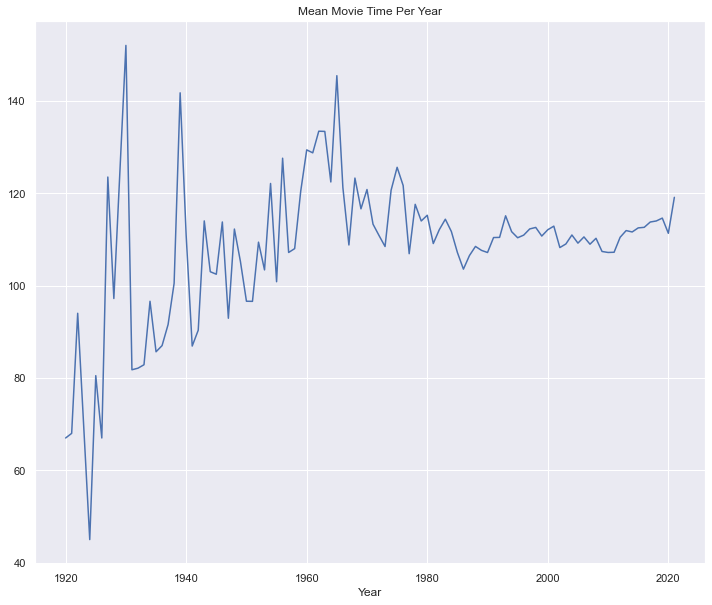

In [21]:
mean_time_year = data.groupby(by=['Year'])['Movie_time_min'].mean()
mean_time_year.plot(kind='line',title='Mean Movie Time Per Year')

In [14]:
genre_description = data[l].describe().T
genre_description.sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
Drama,17483.0,0.520906,0.499577,0.0,0.0,1.0,1.0,1.0
Comedy,17483.0,0.362695,0.480792,0.0,0.0,0.0,1.0,1.0
Action,17483.0,0.340102,0.473757,0.0,0.0,0.0,1.0,1.0
Adventure,17483.0,0.280844,0.449424,0.0,0.0,0.0,1.0,1.0
Crime,17483.0,0.234170,0.423491,0.0,0.0,0.0,0.0,1.0
Thriller,17483.0,0.151118,0.358174,0.0,0.0,0.0,0.0,1.0
Romance,17483.0,0.133844,0.340495,0.0,0.0,0.0,0.0,1.0
Mystery,17483.0,0.117943,0.322550,0.0,0.0,0.0,0.0,1.0
Horror,17483.0,0.112624,0.316141,0.0,0.0,0.0,0.0,1.0
Fantasy,17483.0,0.103987,0.305252,0.0,0.0,0.0,0.0,1.0


In [15]:
# select the most 6 genres
drama = data[data['Drama'] == 1]
comedy = data[data['Comedy'] == 1]
action = data[data['Action'] == 1]
adventure = data[data['Adventure'] == 1]
crime = data[data['Crime'] == 1]
thriller = data[data['Thriller'] == 1]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

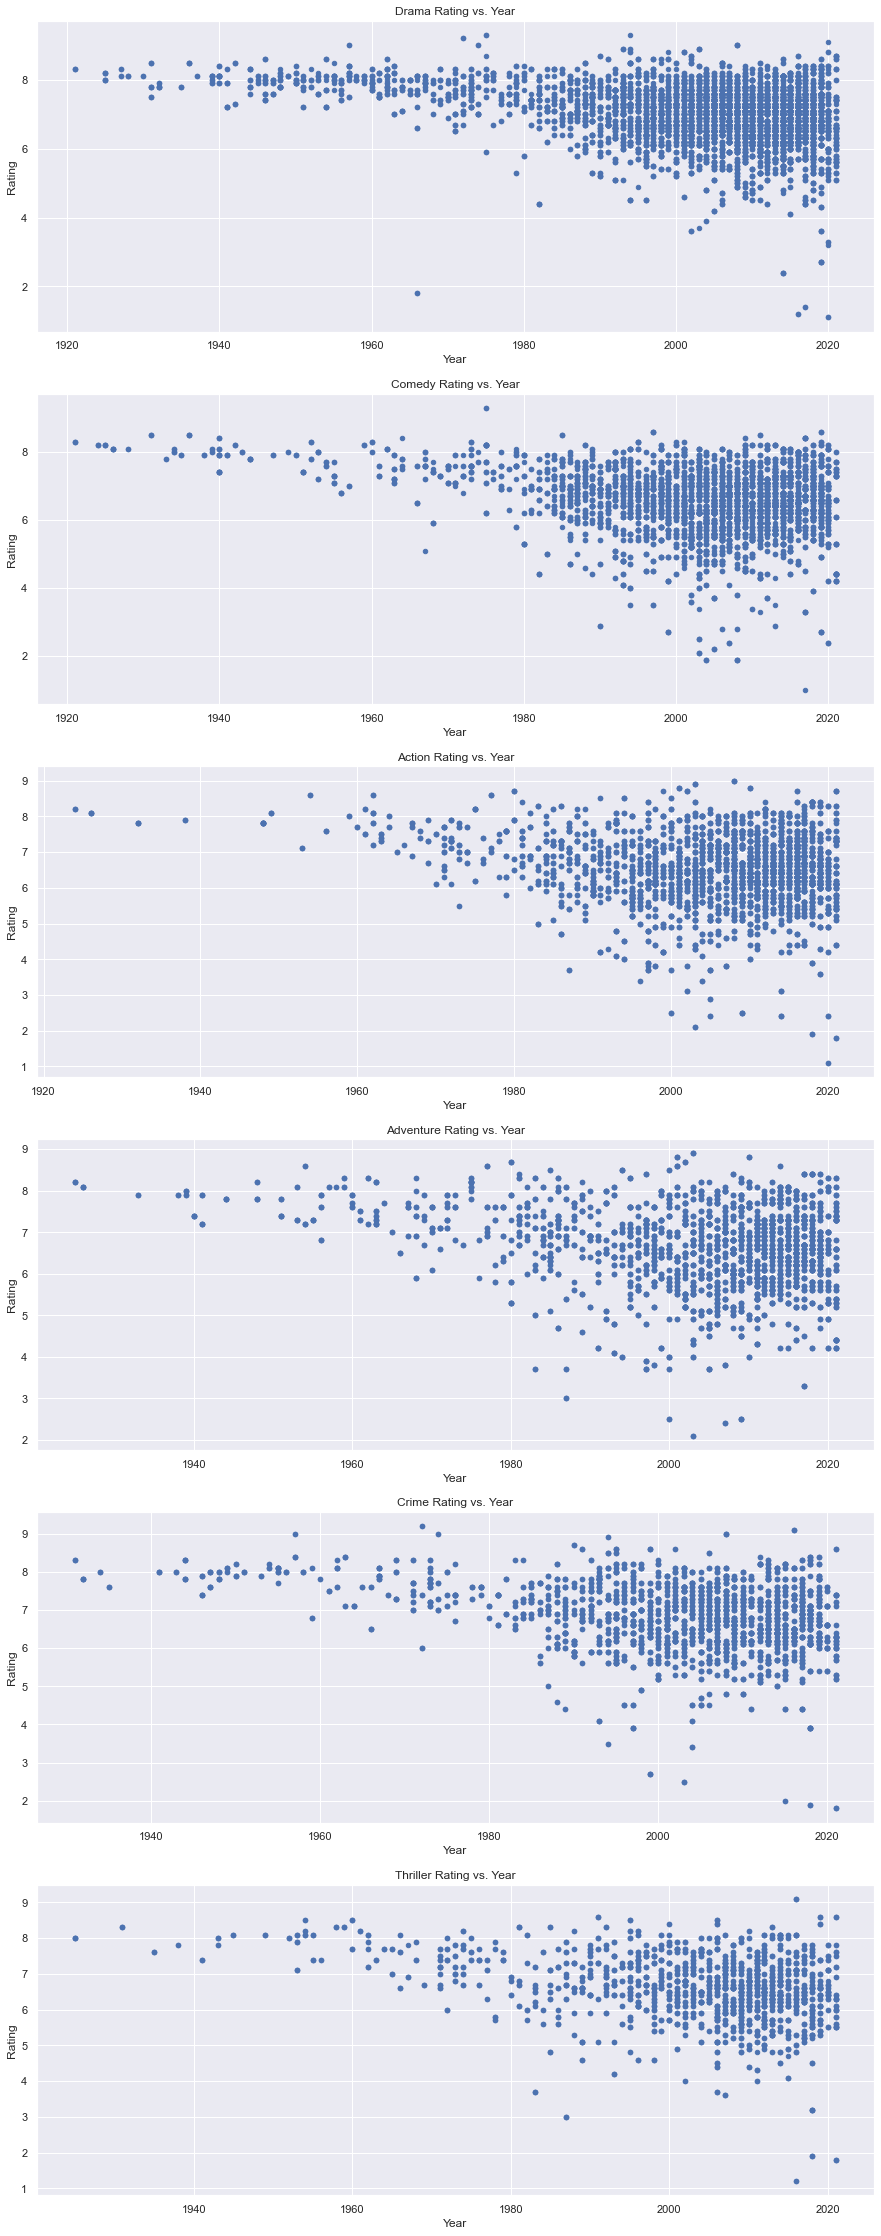

In [16]:
top_6 = [drama,comedy,action,adventure,crime,thriller]

figure, axes = plt.subplots(6, 1, figsize=(15,40))

title = ' Rating vs. Year'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    top_6[i].plot(kind='scatter',x='Year',y='Rating',ax=axes[i],title=Title[i])



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

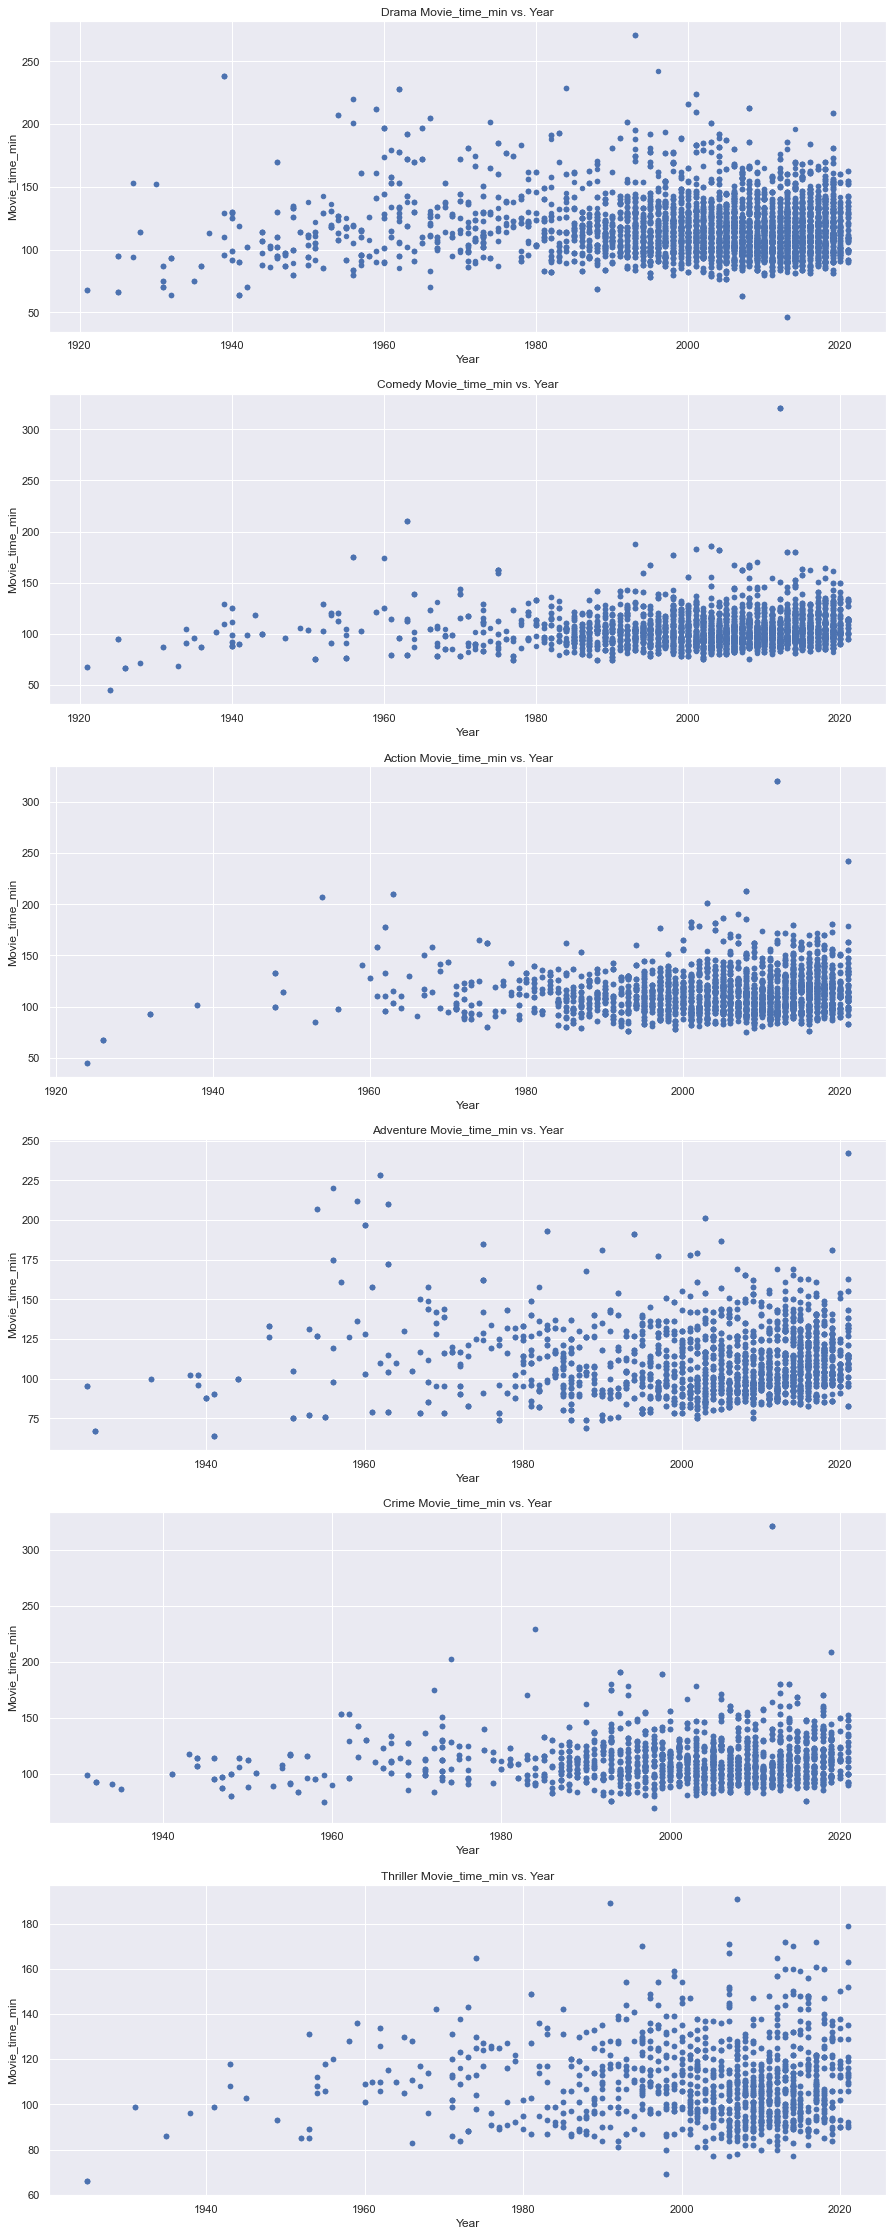

In [17]:
figure, axes = plt.subplots(6, 1, figsize=(15,40))

title = ' Movie_time_min vs. Year'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    top_6[i].plot(kind='scatter',x='Year',y='Movie_time_min',ax=axes[i],title=Title[i])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

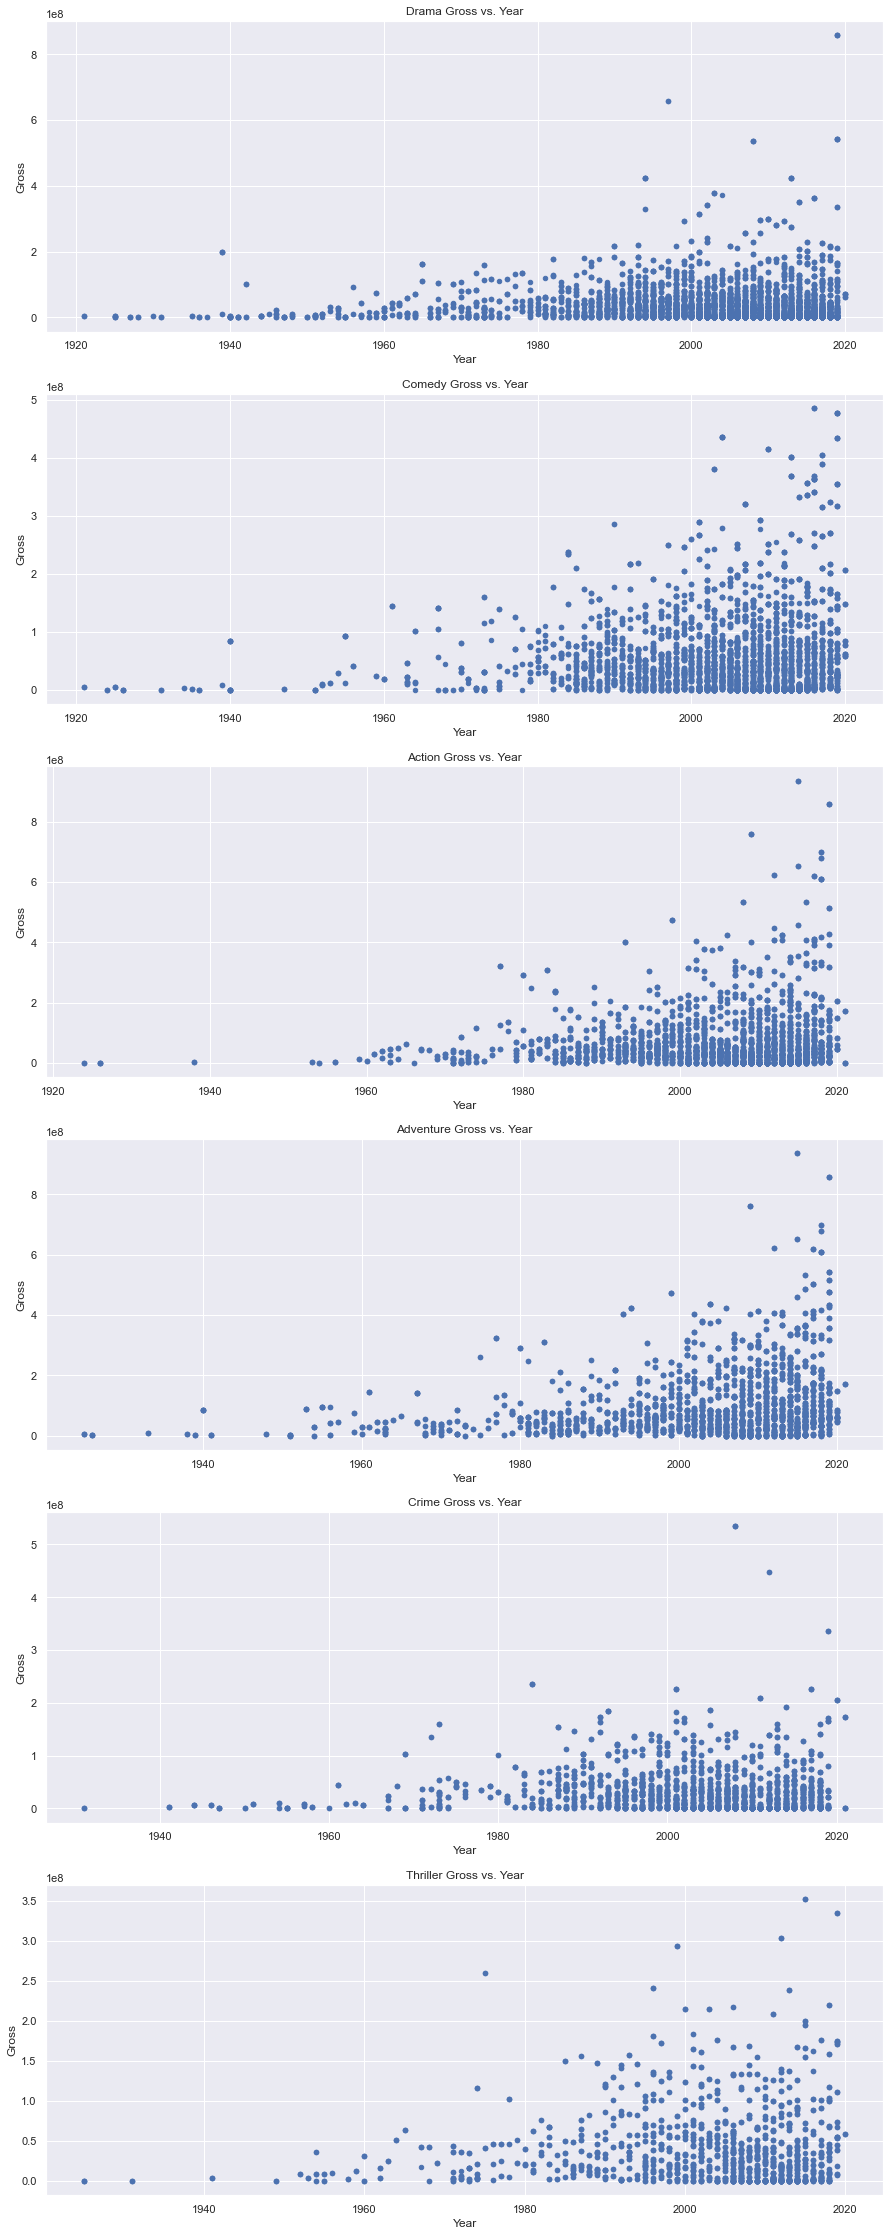

In [35]:
figure, axes = plt.subplots(6, 1, figsize=(15,40))

title = ' Gross vs. Year'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    top_6[i].plot(kind='scatter',x='Year',y='Gross',ax=axes[i],title=Title[i])

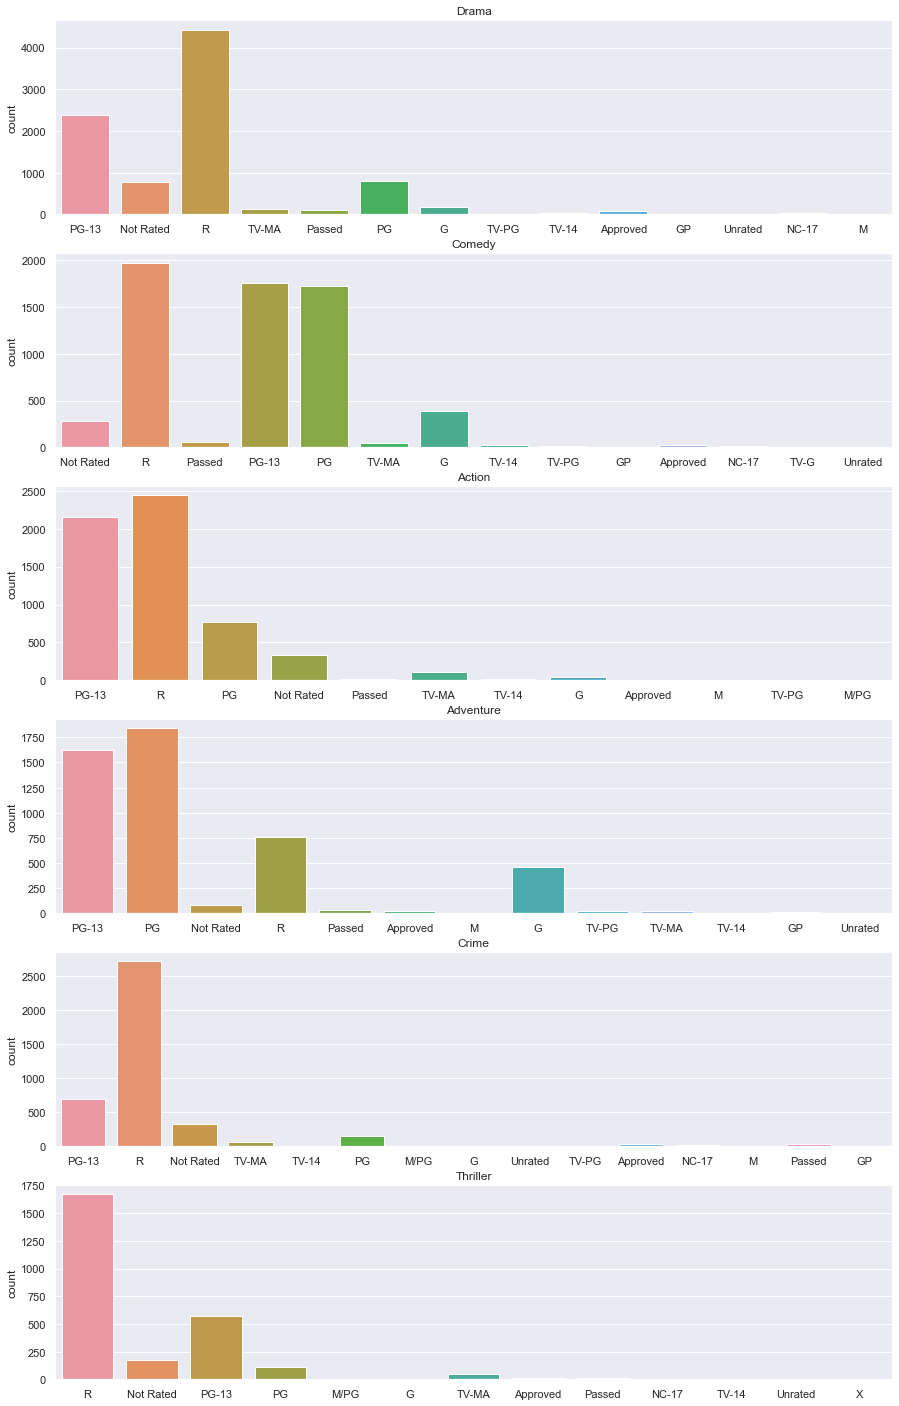

In [36]:
figure, axes = plt.subplots(6, 1, figsize=(15,25))

title = ' Certificate'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    ax = sns.countplot(x='Certificate',data=top_6[i], ax = axes[i])
    ax.set(title=pre[i],xlabel='')

In [18]:
num_vars = data.columns[data.dtypes != 'object']
obj_vars = data.columns[data.dtypes == 'object']

pd.DataFrame(num_vars, columns=['num vars']).T
continuous_vars = ['Rank','Year','Rating','Metascore','Votes','Gross','Movie_time_min']

In [19]:
pd.DataFrame(obj_vars, columns=['obj vars']).T
nominal_vars = ['Title', 'Certificate','Runtime','Genre','URL','Intro']

In [20]:
cnt_missing = data.isnull().sum().sort_values(ascending=False)
cnt_percent = cnt_missing / data.shape[0]

missing_table = pd.DataFrame([cnt_missing, cnt_percent],index=['missing count','missing percent']).T
missing_table = missing_table[missing_table['missing count'] > 0]
missing_table

,missing count,missing percent
Metascore,9962.0,0.569811
Gross,2249.0,0.128639
Certificate,115.0,0.006578


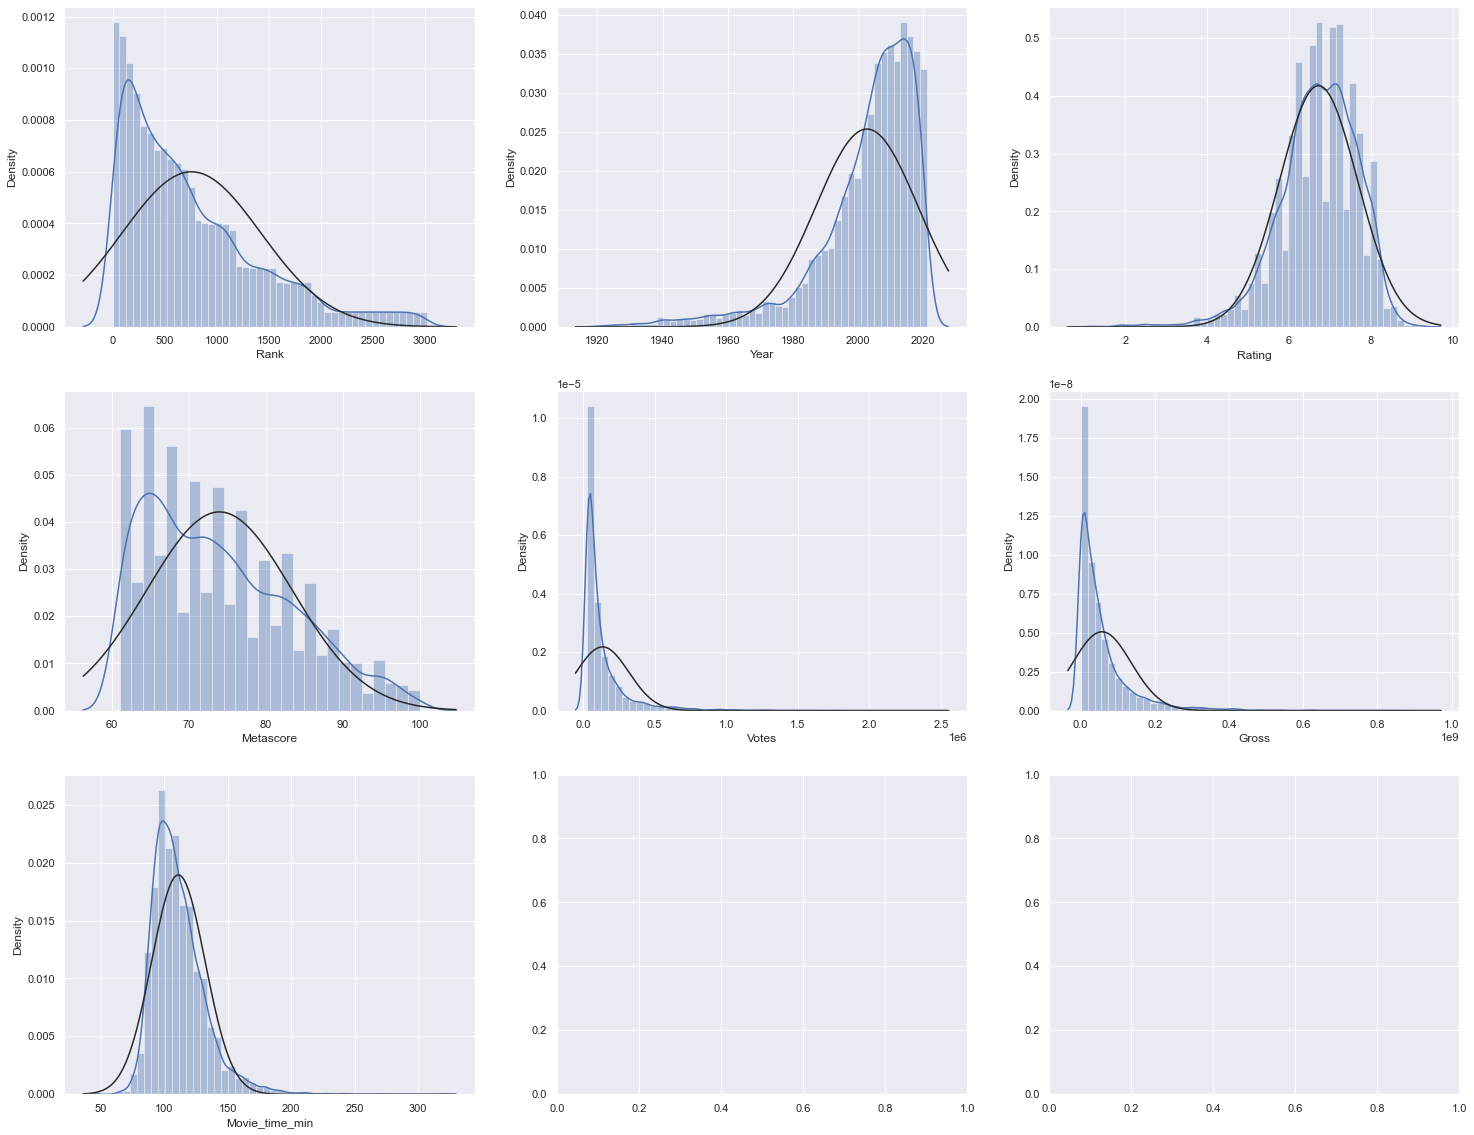

In [40]:
f, ax = plt.subplots(3, 3, figsize=(25, 20))
for i, c in enumerate(continuous_vars):
    sns.distplot(data[c], fit=norm, ax=ax[i//3, i%3])

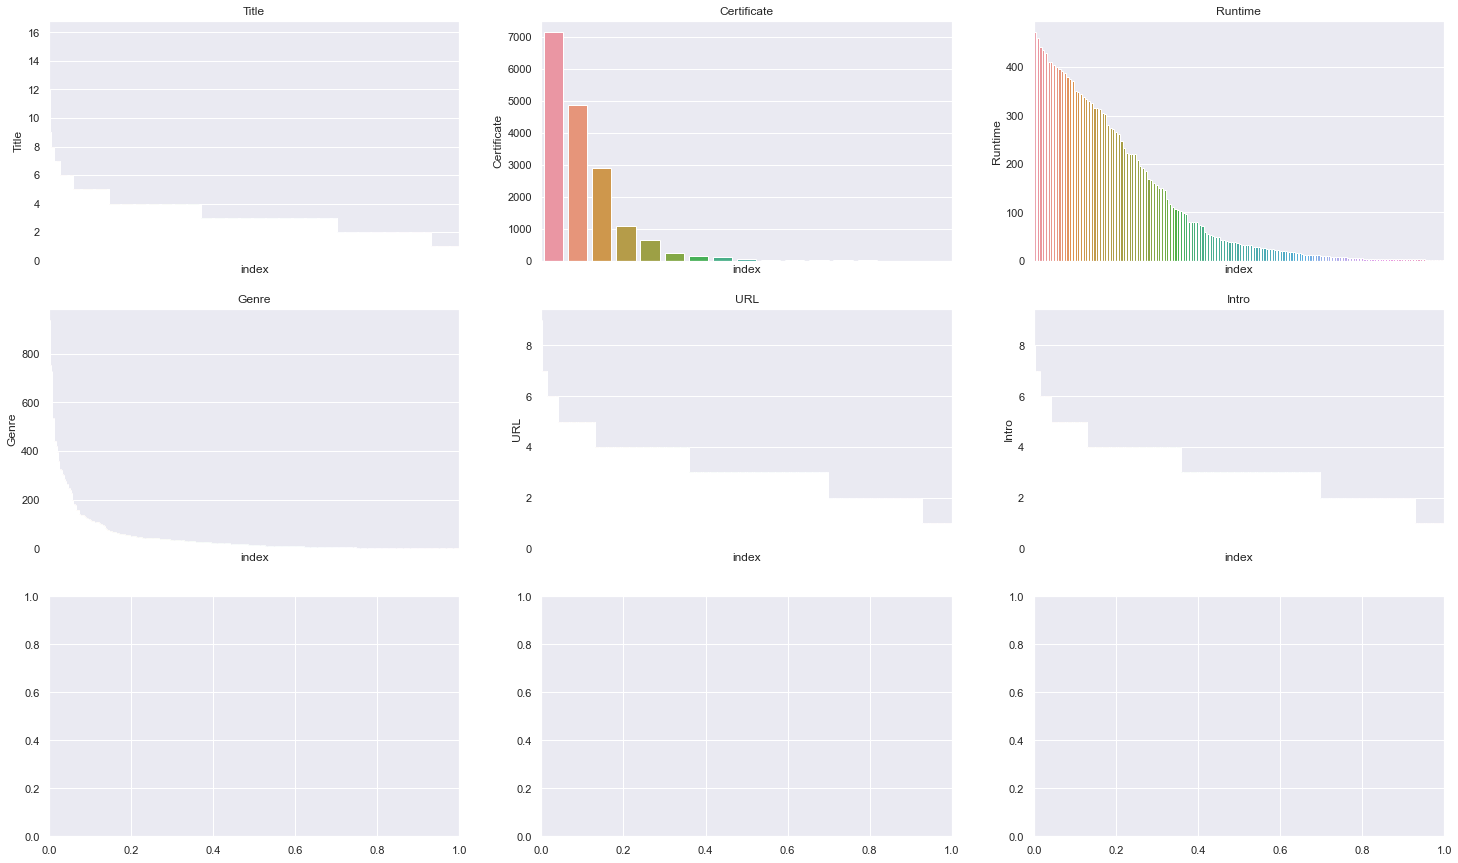

In [41]:
f, ax = plt.subplots(3, 3, figsize=(25, 15))
for i, c in enumerate(nominal_vars):
    g = sns.barplot(data=pd.DataFrame(data[c].value_counts()).reset_index(), x='index', y=c, ax=ax[i//3, i%3])
    g.set(xticks=[])
    g.set(title=c)

<AxesSubplot:>

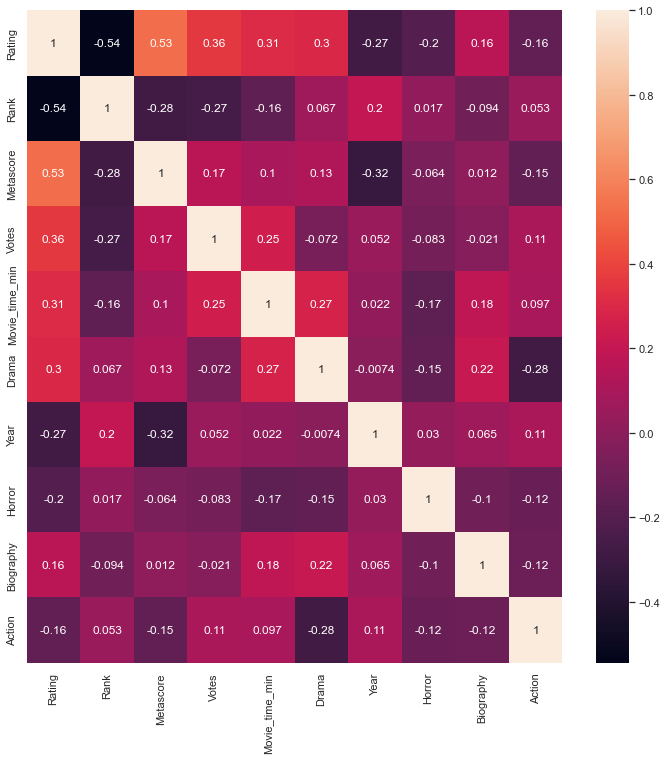

In [21]:
f, ax = plt.subplots(figsize=(12, 12))
highcorr_vars = (abs(data.corr().Rating).sort_values(ascending=False)[:10]).index
sns.heatmap(data[highcorr_vars].corr(), annot=True)

In [43]:
def hypo_test(x, y, cat=False):
    f, ax = plt.subplots(1, 4, figsize=(25, 5))
    if cat:
        sns.boxplot(x=data[x], y=data[y], ax=ax[0])
    else:
        sns.scatterplot(x=data[x], y=data[y], ax=ax[0])
        sns.regplot(x=data[x], y=data[y], ax=ax[0])
    sns.residplot(x=data[x], y=data[y], ax=ax[1])
    sns.distplot(data[x], fit=norm, ax=ax[2])
    probplot(data[x], plot=ax[3])
    plt.show()

C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


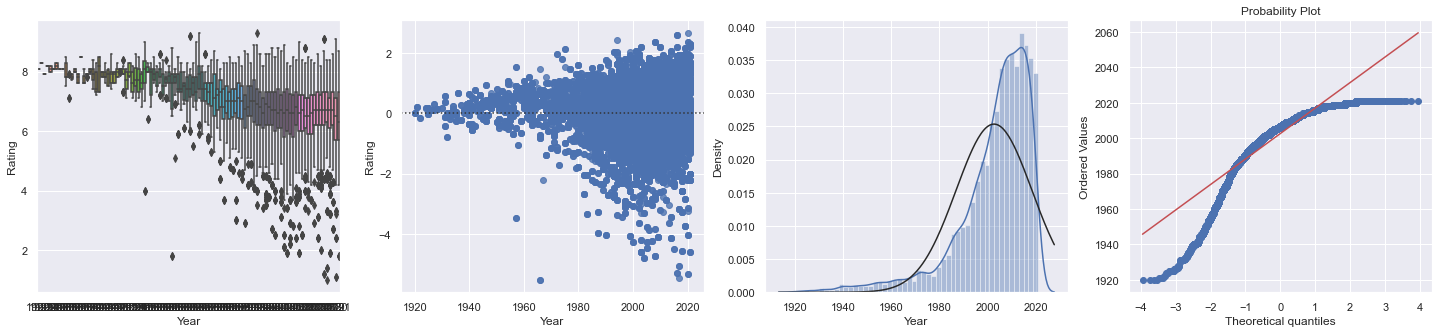

In [35]:
hypo_test('Year','Rating',True)

In [36]:
highcorr_vars

Index(['Rating', 'Rank', 'Metascore', 'Votes', 'Movie_time_min', 'Drama',
       'Year', 'Horror', 'Biography', 'Action'],
      dtype='object')

C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


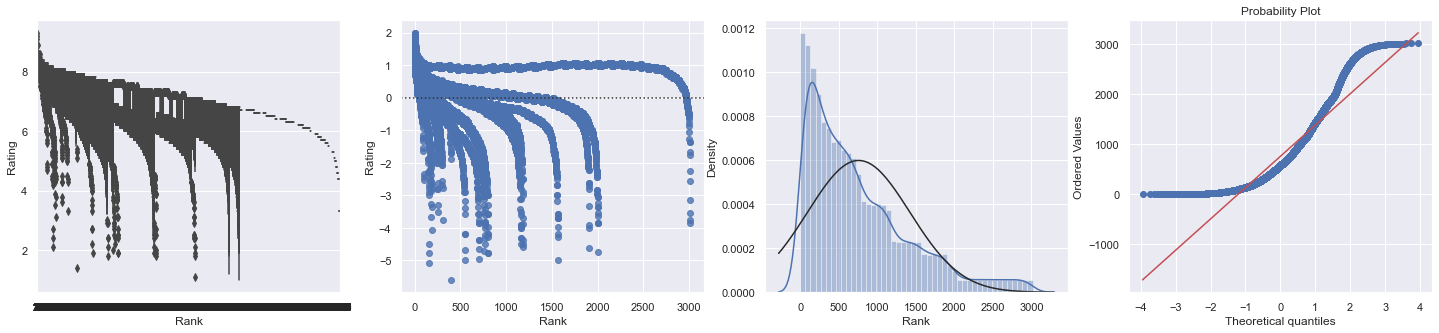

In [37]:
hypo_test('Rank','Rating',True)

C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


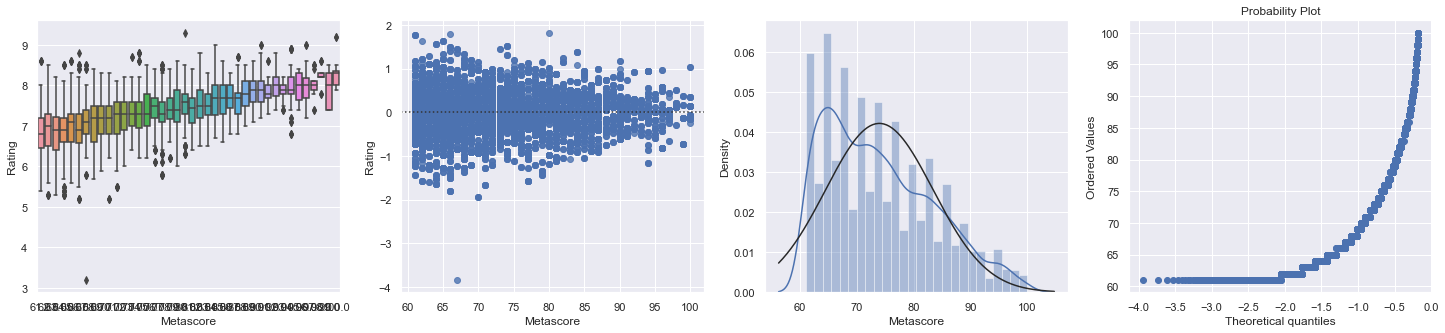

In [38]:
hypo_test('Metascore','Rating',True)

C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


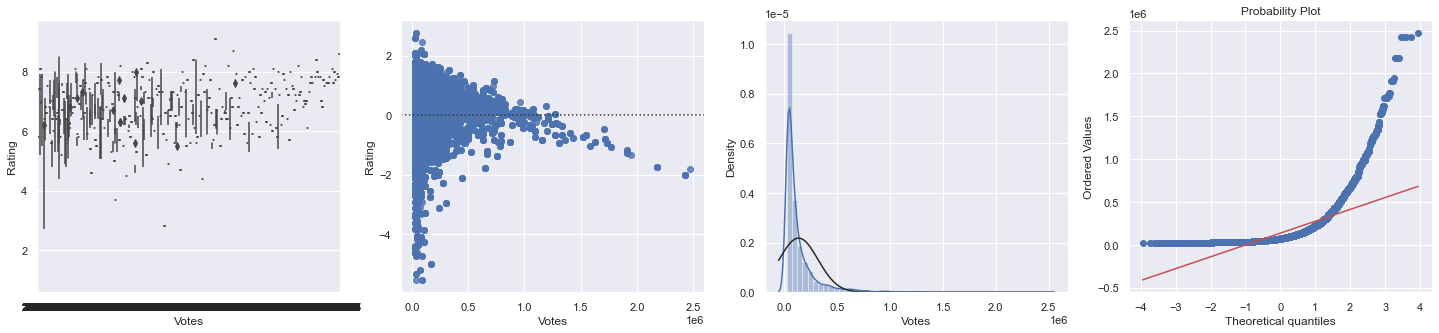

In [39]:
hypo_test('Votes','Rating',True)

C:\Users\qcx60\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


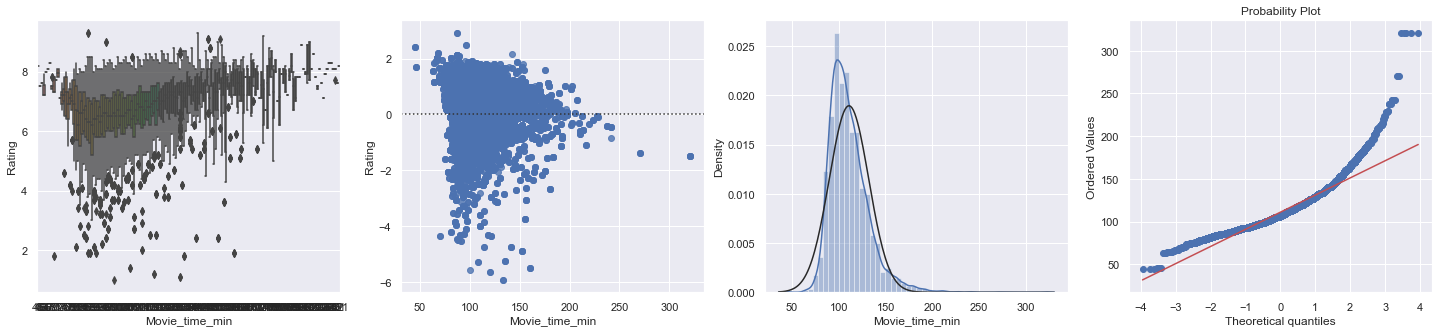

In [40]:
hypo_test('Movie_time_min','Rating',True)

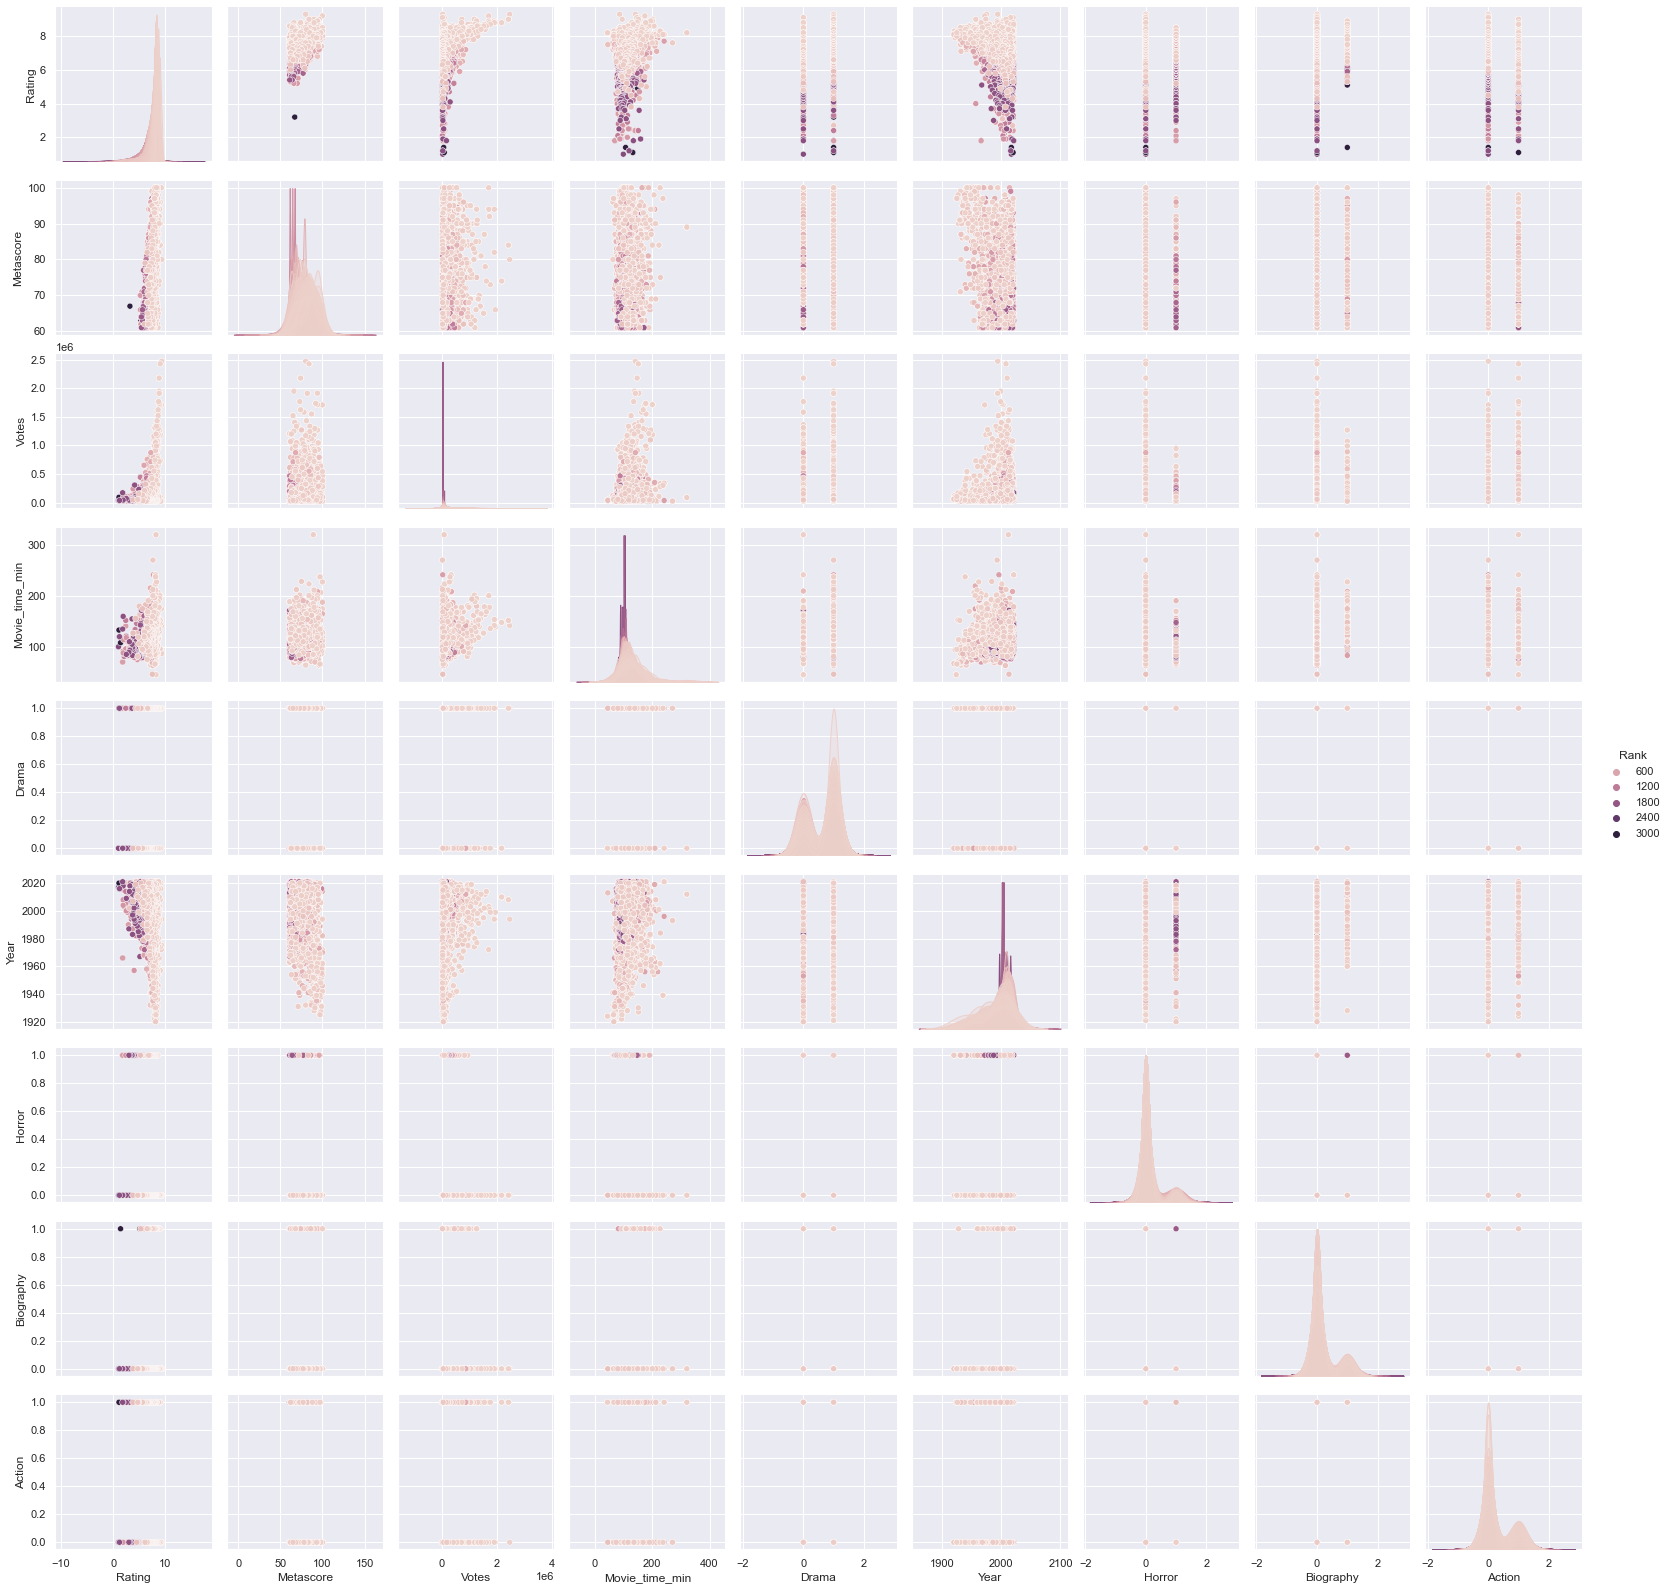

In [45]:
sns.pairplot(data[highcorr_vars], hue ='Rank')

In [22]:
y = data.Rank.values
y

array([  1,   2,   3, ...,  98,  99, 100])

Prepared for Machine Learning data

In [25]:
all_data = data
all_data.to_csv('ml_imdb_data.csv')